#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [8]:
training_data_full = pd.read_csv('training.csv')

In [27]:
images = training_data_full['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

images = np.vstack([images.iloc[i] for i in range(len(images))])

In [22]:
keypoints = training_data_full.drop('Image', axis = 1)

## Including reflected pictures to the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints. 

In [28]:
# building an array of reflected images.
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [29]:
# adding the reflected images to our images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [30]:
images.shape

(14098, 9216)

In [31]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [32]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [33]:
print('Images', images.shape)
print('Keypoints', keypoints.shape)

Images (14098, 9216)
Keypoints (14098, 30)


In [34]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

##  Define a funaction for taking random batches. 

In [35]:
def next_batch(X, labels, batch_size):
    
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [36]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def init_gamma(shape):
    init_gamma_val = tf.constant(1, dtype = tf.float32)
    return tf.Variable(init_gamma_val)

def init_beta(shape):
    init_beta_val = tf.constant(0, dtype = tf.float32)
    return tf.Variable(init_beta_val)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


def bn_layer(input_x, is_training, bn_type = 'normal', decay = 0.999):
    
    """Implements batch normalization. 
    input_x: A Tensor. Is the data to normalize.
    is_training: Bool. Indicates whether we are in training o predictino phase. 
    bn_type: 'normal' or 'convo', indicates over which indeces we take the means. 
              if 'normal', we use only the first index (batch number).
              if 'conv', uses [0,1,2]
    decay: float. decay parameter for the running averages. 
    """
    
    if bn_type == 'normal':
        shape = input_x.shape[1:]
        axes = [0]
    elif bn_type == 'convo':
        shape = input_x.shape[-1]
        axes = [0,1,2]
        
    #running mean and variance to be sued for inference.
    pop_mean = tf.Variable(tf.zeros(shape), trainable=False) 
    pop_var = tf.Variable(tf.ones(shape), trainable=False)
    
    gamma = init_gamma(shape) #in the normalization I am using this is the number of channels. 
    beta = init_beta(shape)
    
    batch_mean, batch_var = tf.nn.moments(input_x, axes)  
    
    def train_phase():
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(input_x, batch_mean, batch_var,
                                                    offset = beta, scale = gamma,
                                                    variance_epsilon=0.0001)
    
    def infer_phase(): 
        return tf.nn.batch_normalization(input_x, pop_mean, pop_var, offset = beta, 
                                  scale = gamma, variance_epsilon=0.0001)
    
        
    return tf.cond(is_training, train_phase, infer_phase)
    

In [62]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)
drop_rate = tf.placeholder(tf.float32)

In [63]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [64]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

#convo1_bn = bn_layer(convo1, training, bn_type = 'normal')    

convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

# Image standarization. I guess it's the same before or after pooling. (maybe not!)
convo1_pin = tf.image.per_image_standardization(convo1_pool) 

convo2 = convolutional_layer(convo1_pin, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.

#convo2_bn = bn_layer(convo2, training, bn_type = 'normal')    

convo2_pool = max_pool_2by2(convo2) # 6 x 6 x 64

convo2_pin = tf.image.per_image_standardization(convo2_pool)

convo2_flat = tf.reshape(convo2_pin,[-1,6*6*64])

#convo2_flat_bn = bn_layer(convo2_flat, training, bn_type='normal')

full_layer_one = tf.nn.relu(normal_full_layer(convo2_flat,1024))


# DROPOUT AND OUTPOUT LAYER

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

keypoints_pred = normal_full_layer(full_one_dropout,30)
#keypoints_pred = normal_full_layer(full_layer_one,30)

In [65]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [66]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [67]:
counter = 5

In [68]:
keypoints_mean = keypoints_train.mean()

# Computing error from the mean in order to have a reference. This is the mark I have to beat. 

mean_keypoints_mse = ((keypoints_cv-keypoints_mean)**2).sum(axis = 1).mean()
mean_keypoints_mse

189.8981537384796

## Training

Currently on step 1000
Train MSE:  25.194702 

CV MSE: 6.079541 



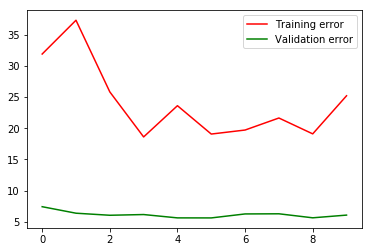

train_losses =  [26.495325, 31.880795, 37.293716, 25.81916, 18.602436, 23.604881, 19.063105, 19.706842, 21.633282, 19.09194, 25.194702] 

cv_losses =  [5.548987, 7.4263415, 6.384514, 6.0545297, 6.16957, 5.6347013, 5.6294513, 6.2667713, 6.2901163, 5.647074, 6.079541]


In [ ]:
num_steps = 5000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    #sess.run(init)
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter))
    train_losses = []
    cv_losses = []
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 70)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             lr:0.0001, drop_rate:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                      drop_rate:0})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    #display(fig)
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_cnn_1"  )
    #counter +=1
    #print(counter)

## Predicting

In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_1")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, drop_prob:0 })
    

In [ ]:
predictions.shape

In [ ]:
x_cv.shape

In [ ]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'y*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

# Adding one more layer

In [60]:
tf.reset_default_graph()

In [50]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)
drop_rate = tf.placeholder(tf.float32)

In [51]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [52]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.

convo2_pool = tf.nn.max_pool(convo2, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 12 x 12 x64

convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

convo3_pool = tf.nn.max_pool(convo3, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 6 x 6 x 128


convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])

full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))

# DROPOUT AND OUTPOUT LAYER

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

keypoints_pred = normal_full_layer(full_one_dropout,30)
#pre_pred_bn = bn_layer(full_layer_one, is_training =training)
#keypoints_pred = normal_full_layer(pre_pred_bn,30)


In [53]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

In [54]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [55]:
counter = 1

## Training

Currently on step 2000
Train MSE:  6.0034313 

CV MSE: 6.8565226 

train_losses =  [8.154087, 10.735448, 10.273431, 7.0712442, 9.3896055, 8.377527, 9.195991, 6.2888794, 6.3905506, 6.6801705, 5.9180226, 7.575799, 12.344923, 6.3330545, 7.584003, 6.8554406, 9.398245, 7.051716, 6.4051685, 6.2130957, 6.0034313] 

cv_losses =  [6.3664775, 5.9092455, 6.3490367, 9.011761, 5.9299126, 7.7474527, 6.9178557, 6.2592616, 7.002719, 5.5225196, 5.631848, 5.181668, 5.3268423, 5.124134, 5.420479, 5.008431, 5.0583234, 5.4662604, 5.5826917, 5.0870233, 6.8565226]


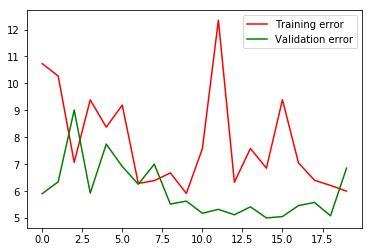

In [59]:
num_steps = 2000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    #sess.run(init)
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_0")
    train_losses = []
    cv_losses = []
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 70)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             lr:0.001, drop_rate:0.1})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                      drop_rate:0})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    #display(fig)
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    saver.save(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn_1"  )
    #counter +=1
    #print(counter)

In [57]:
np.sqrt(cv_losses[-1])

2.4039836

In [58]:
counter

0

In [ ]:
train_losses =  [6535.8877, 61.39344, 37.864075, 26.085787, 28.91527, 24.441002, 18.022243, 16.84032, 17.779926, 
                 14.69021, 17.242184, 14.294025, 19.403442, 15.109872, 13.780137, 19.672417, 11.565442, 14.270986, 
                 16.974945, 21.37409, 13.511208, 17.027847, 10.855091, 11.093475, 11.715345, 13.354714, 9.111947, 
                 10.129999, 9.4107895, 13.770896, 11.673254, 10.138294, 8.769963, 9.415643, 11.772252, 8.668999, 
                 8.178522, 9.799023, 13.73167, 8.959081, 8.153407, 12.688569, 9.571056, 6.663531, 9.001301, 6.753181, 
                 27.725986, 6.8633637, 9.252424, 9.762126, 9.930816, 8.154087, 10.735448, 10.273431, 7.0712442, 
                 9.3896055, 8.377527, 9.195991, 6.2888794, 6.3905506, 6.6801705, 5.9180226, 7.575799, 12.344923, 
                 6.3330545, 7.584003, 6.8554406, 9.398245, 7.051716, 6.4051685, 6.2130957, 6.0034313]   

cv_losses =  [963.3741, 25.025454, 17.231789, 13.623633, 11.917282, 10.928918, 10.71747, 10.072091, 9.57578, 9.531369, 
              9.023463, 12.0198145, 8.823386, 10.083969, 8.164754, 8.5830965, 11.283038, 8.301348, 7.7337527, 7.9439244, 
              8.903738, 8.114471, 13.893348, 7.6728783, 8.572736, 7.112711, 7.0409703, 7.1724186, 8.157807, 7.20243, 
              7.389675, 7.4858947, 7.008111, 7.6529336, 6.913995, 7.680303, 6.4630947, 6.5593166, 7.323199, 7.6404624, 
              6.582255, 6.140972, 7.489008, 9.182387, 6.132248, 7.671939, 6.6811576, 6.0704236, 6.243296, 6.8098063, 
              5.779137, 6.3664775, 5.9092455, 6.3490367, 9.011761, 5.9299126, 7.7474527, 6.9178557, 6.2592616, 7.002719, 
              5.5225196, 5.631848, 5.181668, 5.3268423, 5.124134, 5.420479, 5.008431, 5.0583234, 5.4662604, 5.5826917, 
              5.0870233, 6.8565226]
